##Importing Libraries

In [0]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
plotly.tools.set_credentials_file(username='rounakbanik', api_key='xTLaHBy9MVv5szF4Pwan')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
!pip install xgboost

In [0]:
!pip install plotly

##Uploading movies_metadata file

In [0]:
df = pd.read_csv('/Users/jasmeetkaur/Desktop/Desktop - jasmeet’s MacBook Pro/ANDREW/ASSIGNMENT 2/the-movies-dataset/movies_metadata.csv')

In [0]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSE,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,30/10/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,FALSE,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,15/12/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,FALSE,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,22/12/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,FALSE,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,22/12/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,FALSE,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,10/02/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [0]:
df = df.drop(columns=['adult', 'belongs_to_collection','homepage', 'imdb_id', 'original_language','original_title','poster_path','spoken_languages','status','video','budget','production_companies'])

##Extracting countries' names from 'production_countries' attribute

In [0]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] 
for i in x] if isinstance(x, list) else [])

In [0]:
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [0]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


##Famous countries for movies' production

In [0]:
#Creating world map to show number of movies produced in each country which shows the favorite destination among directors for shooting
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(0, 102, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(0,0,0)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

In [0]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [0]:
def get_month(x):
    try:
        return month_order[int(str(x).split('/')[1]) - 1]
    except:
        return np.nan

In [0]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('/'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [0]:
def get_year(x):
    try:
        return year_order[int(str(x).split('/')[1]) - 1]
    except:
        return np.nan

In [0]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)
df['year'] = df['release_date'].apply(get_year)

In [0]:
df.head()

,genres,id,overview,popularity,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,day,month,year
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",21.9469,[United States of America],30/10/1995,373554033.0,81.0,NaN,Toy Story,7.7,5415.0,NaN,Oct,NaN
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.0155,[United States of America],15/12/1995,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,NaN,Dec,NaN
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,11.7129,[United States of America],22/12/1995,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,NaN,Dec,NaN
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",3.85949,[United States of America],22/12/1995,81452156.0,127.0,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,NaN,Dec,NaN
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,8.38752,[United States of America],10/02/1995,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,NaN,Feb,NaN


##Number of movies released in each Month

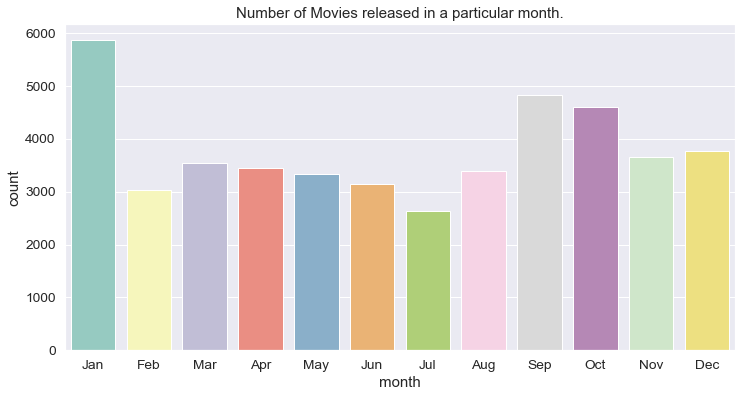

In [0]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order, palette="Set3")

##Revenue collected in each month

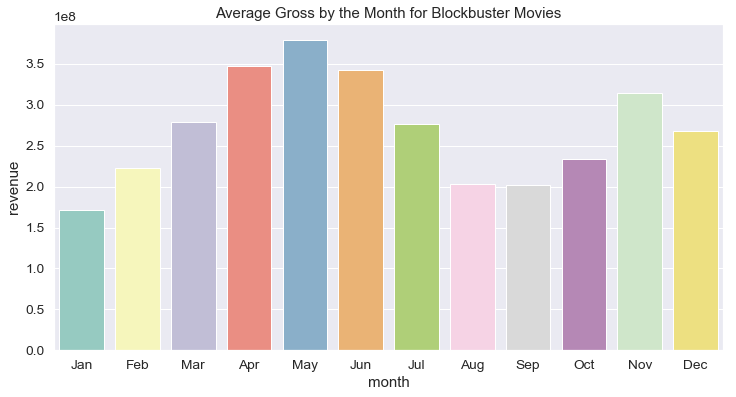

In [0]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['month'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='month', y='revenue', data=month_mean, order=month_order, palette ="Set3")

In [0]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [0]:
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

##Word Cloud for titles

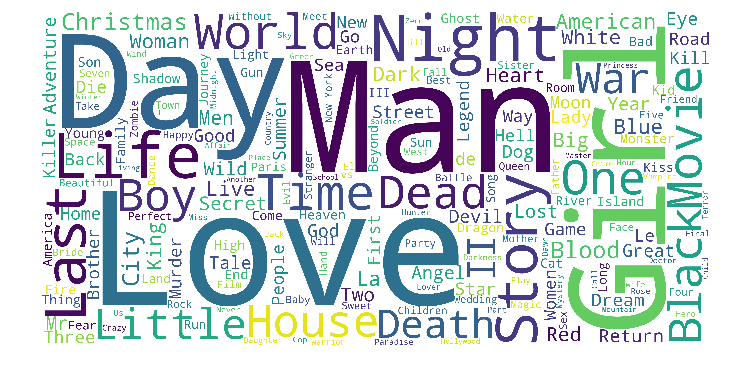

In [0]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(12,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

##Word Cloud for Overviews

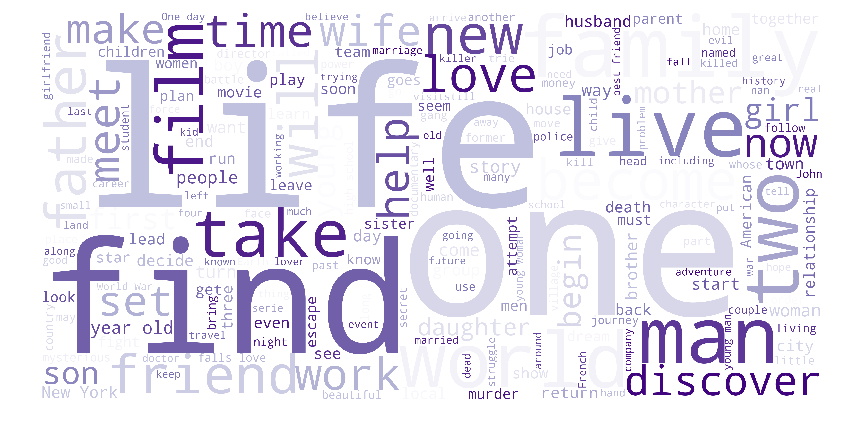

In [0]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000, colormap="Purples").generate(overview_corpus)
plt.figure(figsize=(14,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()